# Import

In [48]:
from math import sin, pi
import numpy as np
from numpy import arange, argmax, asarray, vstack
from numpy.random import normal, random
from scipy.stats import norm
from scipy.optimize import fmin_l_bfgs_b
from matplotlib import pyplot as plt
from warnings import catch_warnings, simplefilter
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
import time

np.set_printoptions(suppress=True)

# Variables

In [49]:
dims = 4 # number of parameters
n = 5   # initial samples

# Underlying Objective Function

In [50]:
def objective(x, noise=0.1):
    noise = normal(loc=0, scale=noise)
    return -(x[0]/2 - 1)**2 + x[1]/500 + x[2]/20 + x[3]/1000 + noise

# Parameter space + <i>n</i> random samples

In [51]:
# Parameter space
#num=10
X_space = [
    np.linspace(start=0, stop=5, num=21),
    np.linspace(start=10, stop=100, num=46),
    #np.linspace(start=0, stop=1, num=num),
    np.linspace(start=0, stop=5, num=21),
    np.linspace(start=100, stop=300, num=101)
    #np.linspace(start=80, stop=120, num=num),
]

# Take n samples
n_samples = []
for i in range(n):
    sample = []
    for j in range(dims):
        sample.append(np.random.choice(X_space[j],1))
    n_samples.append( np.array(sample).ravel() )
n_samples = np.array(n_samples)

# (Sample) obsevations are always considered noisy
ynoise = []
for i in range(n):
    ynoise.append(objective(n_samples[i]))

In [52]:
n_samples

array([[  4.25,  30.  ,   4.75, 248.  ],
       [  4.25,  48.  ,   1.25, 198.  ],
       [  3.5 ,  44.  ,   1.75, 182.  ],
       [  2.75,  70.  ,   2.25, 196.  ],
       [  3.25,  90.  ,   1.25, 274.  ]])

# Plot points

Optima: x=[  2.5  14.    3.  148. ], y=0.1770338853672199


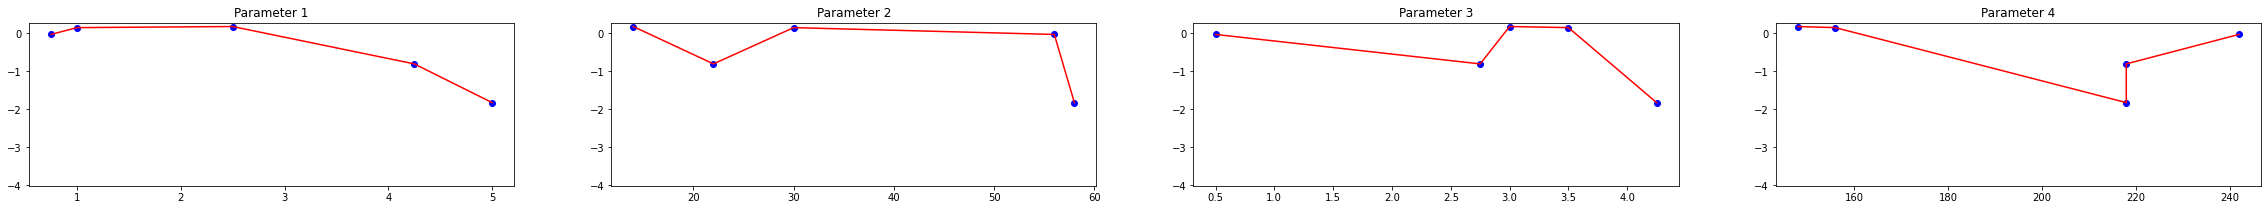

In [39]:
def plot_dims(n_samples, ynoise):
    fig, axs = plt.subplots(1,dims,figsize=(40,3))
    
    for i in range(dims):
        list1, list2 = zip(*sorted(zip(n_samples[:,i],ynoise)))
        axs[i].plot(list1,list2,c='r') # plot()
        for j in range(len(n_samples)):
            
            axs[i].scatter(n_samples[j][i], ynoise[j],c='b')
            axs[i].set_ylim(min(ynoise) - abs(min(ynoise)*1.2) ), max(ynoise) + abs(max(ynoise)*1.2)
            axs[i].set_title(f"Parameter {i+1}")

    optimal_y = np.max(np.array(ynoise))
    optimal_x = str(n_samples[np.argmax(np.array(ynoise))])
    print(f"Optima: x={optimal_x}, y={optimal_y}")
    plt.show()

plot_dims(n_samples, ynoise)

# Fit GP model

In [40]:
# Standardize data
def standardize(x):
    return (x - np.mean(x,axis=0)) / np.std(x,axis=0)

# GP model predictions
def surrogate(model, x):
    # x = standardize(x)
    return model.predict(x ,return_std=True)

# Optimal parameters using acq. function
def opt_acquisition(X, Xsamples, model):
    print("enter opt", time.time()-start_time)
    scores = acquisition(X,Xsamples, model)
    ix = argmax(scores)
    print("optimal acq", time.time()-start_time)
    return Xsamples[ix], ix

In [41]:
# Probability of Improvement (PI)
def PI(X, Xsamples, model):
    yhat, _ = surrogate(model, X)
    best = max(yhat)
    mu, std = surrogate(model, Xsamples)
    probs = norm.cdf((mu - best) / (std+1E-9))
    return probs

In [42]:
# Expected Improvement (EI)
def EI(X, Xsamples, model):
    Xi = 0.1
    print("Enter EI", time.time()-start_time)
    yhat, _ = surrogate(model, X)
    best = max(yhat)
    print("yhat", time.time()-start_time)
    mu, std = surrogate(model, Xsamples)
    print("mu/std", time.time()-start_time)
    imp = (mu - best - Xi)
    with np.errstate(divide='warn'):
        z = imp / std
        probs = imp *  norm.cdf( z ) + std * norm.pdf( z )
        probs[std==0.0] = 0.0
    print("probs", time.time()-start_time)
    return probs

In [43]:
# Lower Confidence Bounds (LCB)
def LCB(X, Xsamples, model):
    kappa = 1.2
    mu, std = surrogate(model, Xsamples)
    probs = mu - kappa * std
    return 1 - probs

In [44]:
# Upper Confidence Bounds (UCB)
def UCB(X, Xsamples, model):
    kappa = 1.2
    mu, std = surrogate(model, Xsamples)
    probs = mu + kappa * std
    return probs

In [45]:
acquisition = EI

In [46]:
#kernel = 0.1**2 * RBF(1)
start_time = time.time()
model = GaussianProcessRegressor() # kernel=kernel, n_restarts_optimizer=1
model.fit(n_samples,ynoise)
print('DEBUG: model fit', time.time()-start_time)

Xsamples = np.array( np.meshgrid(X_space[0],X_space[1],X_space[2],X_space[3])).T.reshape(-1,dims)
print('DEBUG: mesh grid')
ysamples, std = surrogate(model, Xsamples)
print('DEBUG: surrogate')

DEBUG: model fit 0.0039899349212646484
DEBUG: mesh grid
DEBUG: surrogate


In [ ]:
plt.scatter(np.arange(ysamples.shape[0]),ysamples)
plt.scatter(np.arange(std.shape[0]),ysamples+std)
plt.show()
counts, bins, bars = plt.hist(std)
print(*zip(bins,counts))
print(p)

DEBUG: loop start
enter opt 0.0
Enter EI 0.0
yhat 0.08078432083129883
mu/std 171.8224217891693
probs 172.0847203731537
optimal acq 172.0907039642334
DEBUG: opt_acq complete
DEBUG: objective complete
>x=[  1.5   48.     4.75 274.  ], f()=[0.39809291], actual=0.545


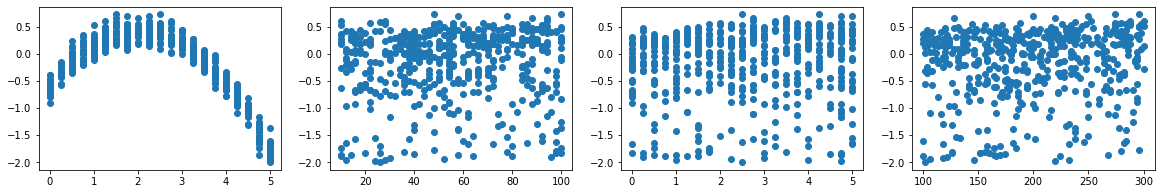

DEBUG: loop start
enter opt 173.36338210105896
Enter EI 173.36338210105896
yhat 173.43020582199097
mu/std 333.09749460220337
probs 333.3445053100586
optimal acq 333.35251665115356
DEBUG: opt_acq complete
DEBUG: objective complete
>x=[  1.75  48.     3.5  274.  ], f()=[0.45000038], actual=0.529375


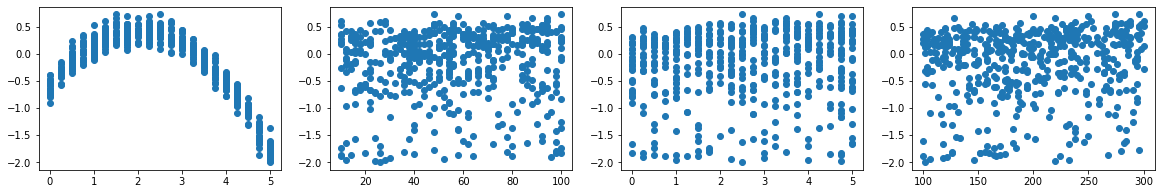

DEBUG: loop start
enter opt 334.0428123474121
Enter EI 334.0428123474121
yhat 334.10990166664124
mu/std 493.18494725227356
probs 493.4390845298767
optimal acq 493.4390845298767
DEBUG: opt_acq complete
DEBUG: objective complete
>x=[  1.  100.    1.5 296. ], f()=[0.39078647], actual=0.321


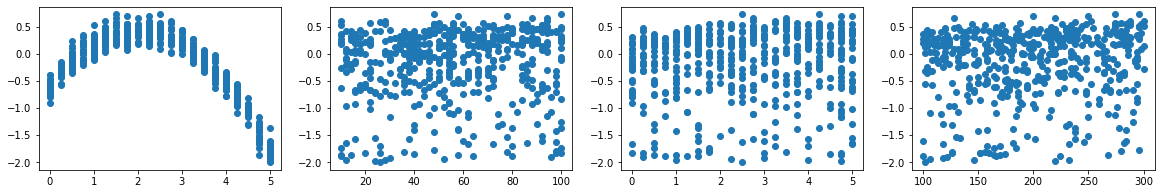

DEBUG: loop start
enter opt 494.089154958725
Enter EI 494.089154958725
yhat 494.1744611263275
mu/std 653.2581300735474
probs 653.4603445529938
optimal acq 653.4669353961945
DEBUG: opt_acq complete
DEBUG: objective complete
>x=[  0.5 100.    3.  296. ], f()=[0.39078646], actual=0.08349999999999999


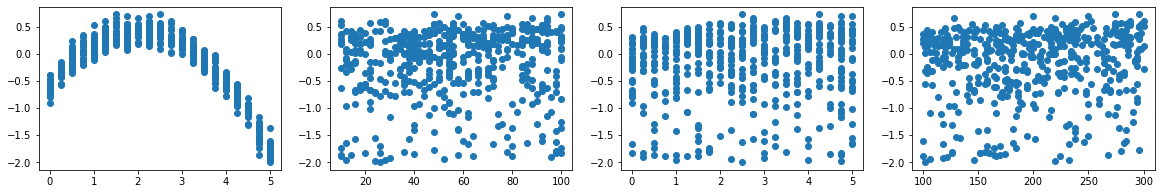

DEBUG: loop start
enter opt 654.0566298961639
Enter EI 654.0566298961639
yhat 654.1117913722992
mu/std 812.2724599838257
probs 812.4744465351105
optimal acq 812.490068435669
DEBUG: opt_acq complete
DEBUG: objective complete
>x=[  2.5  100.     2.25 296.  ], f()=[0.52752508], actual=0.546


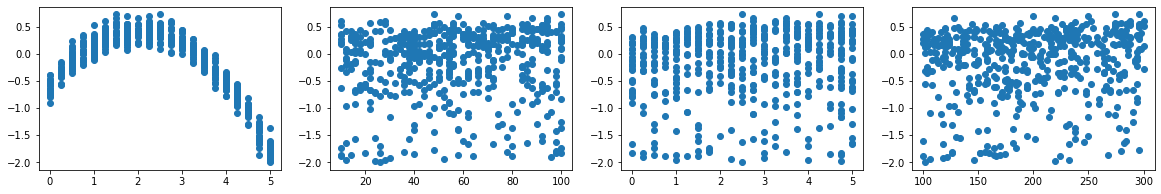

Best Result: x=[  1.5 100.    2.5 296. ], y=0.7300852334568934


In [33]:
global start_time
start_time = time.time()
# Run K times
K = 5
X = n_samples.copy()
y = ynoise.copy()
for i in range(K):
    print('DEBUG: loop start')
    x, ix = opt_acquisition(X,Xsamples,model)
    print('DEBUG: opt_acq complete')
    actual = objective(x,0)
    print('DEBUG: objective complete')
    est, _ = surrogate(model, [x])
    print(f'>x={x}, f()={est}, actual={actual}')
    Xsamples = np.delete(Xsamples, ix, axis=0)
    X = vstack((X,[x]))
    y.append(actual) 
    model.fit(X,y)

    fig, axs = plt.subplots(1,dims, figsize=(20,3))
    for dim in range(dims):
        axs[dim].scatter(X[:,dim], y)
    plt.show()

ix = argmax(y)
print(f'Best Result: x={X[ix]}, y={y[ix]}')